In [12]:
#데이터셋 생성


'''
#elec load
#전력 적산 데이터만 있는 원본 데이터 호출
df = pd.read_csv("C:/Users/Sejong/OneDrive - Sejong University/바탕 화면/data/202306_IITP_RAW_DATA/ELEC_RAW.csv", header=None).reset_index(drop = True)
df = df[[0, 1, 2]]
df.rename(columns = {0: 'house_index', 1:'date', 2:'elec_accu'}, inplace = True)
df['date'] = pd.to_datetime(df['date'])
for i in range(1, 349):
    file = df[df['house_index']==i]
    globals()["elec_df{}".format(i)]= file

#water load
df = pd.read_csv("C:/Users/Sejong/OneDrive - Sejong University/바탕 화면/data/202306_IITP_RAW_DATA/WATER_RAW.csv", header=None).reset_index(drop = True)
df = df[[0, 1, 2]]
df.rename(columns = {0: 'house_index', 1:'date', 2:'water_accu'}, inplace = True)

#date string 분해
df['Y'] = df.date.str.split('-').str[0]
df['M'] = df.date.str.split('-').str[1]
df['D'] = df.date.str.split('-').str[2]
df['h'] = df.date.str.split(':').str[0]
df['m'] = df.date.str.split(':').str[1]
df['s'] = df.date.str.split(':').str[2]
df['h'] = df.h.str.split(' ').str[1]
df['D'] = df.D.str.split(' ').str[0]

df = df.astype({'Y':'int64', 'M':'int64', 'D':'int64', 'h':'int64', 'm':'int64', 's':'int64'})

#date 예외 제거
df = df[df['m']<60]
df = df[df['h']<24]
df = df[df['s']<60]

#date to datetime
df['date'] = pd.to_datetime(df['date'])
for i in range(1, 349):
    file = df[df['house_index']==i]
    globals()["water_df{}".format(i)]= file

# 기존 10분 데이터에서 1시간 데이터로 변환
#1시간 단위로 변환
for j in range(1, 349):
    date = pd.date_range("2022-10-01 00:00:00", "2023-03-28 00:00:00", freq='1h')
    null_df = pd.DataFrame(columns=['house_index', 'date', 'elec_accu'])
    null_df['date'] = date
    for i in range(len(null_df)):
        try:
            a = null_df.loc[i, 'date']
            b = null_df.loc[i+1, 'date']

            per1h = eval('elec_df'+str(j))[eval('elec_df'+str(j))['date'].between(a, b)]
            total = per1h['elec_accu'].max()
            null_df.loc[i+1, 'elec_accu'] = total

            per1h = eval('water_df'+str(j))[eval('water_df'+str(j))['date'].between(a, b)]
            total = per1h['water_accu'].max()
            null_df.loc[i+1, 'water_accu'] = total

        except:
            print(j)
    null_df['house_index'] = j
    null_df = null_df.dropna(axis = 0)
    globals()["total_df{}".format(j)]= null_df


#모든 house index 병합
li = []
for i in range(1, 349):
    x = eval('total_df'+str(i))
    #x['lag1_usage'] = x['usage'].shift(1)
    #x['lag2_usage'] = x['usage'].shift(2)
    x['elec_usage'] = x.elec_accu.diff(periods = 1)
    x['water_usage'] = x.water_accu.diff(periods = 1)
    x = x.dropna(axis = 0)
    li.append(x)
print(li)

data = pd.concat(li, ignore_index=True)

data.to_csv("C:/Users/Sejong/Downloads/total_data(elec, water).csv")
'''

'\n#elec load\ndf = pd.read_csv("C:/Users/Sejong/OneDrive - Sejong University/바탕 화면/data/202306_IITP_RAW_DATA/ELEC_RAW.csv", header=None).reset_index(drop = True)\ndf = df[[0, 1, 2]]\ndf.rename(columns = {0: \'house_index\', 1:\'date\', 2:\'elec_accu\'}, inplace = True)\ndf[\'date\'] = pd.to_datetime(df[\'date\'])\nfor i in range(1, 349):\n    file = df[df[\'house_index\']==i]\n    globals()["elec_df{}".format(i)]= file\n\n#water load\ndf = pd.read_csv("C:/Users/Sejong/OneDrive - Sejong University/바탕 화면/data/202306_IITP_RAW_DATA/WATER_RAW.csv", header=None).reset_index(drop = True)\ndf = df[[0, 1, 2]]\ndf.rename(columns = {0: \'house_index\', 1:\'date\', 2:\'water_accu\'}, inplace = True)\n\n#date string 분해\ndf[\'Y\'] = df.date.str.split(\'-\').str[0]\ndf[\'M\'] = df.date.str.split(\'-\').str[1]\ndf[\'D\'] = df.date.str.split(\'-\').str[2]\ndf[\'h\'] = df.date.str.split(\':\').str[0]\ndf[\'m\'] = df.date.str.split(\':\').str[1]\ndf[\'s\'] = df.date.str.split(\':\').str[2]\ndf[\'h\'] = 

In [1]:
#라이브러리 호출
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std = StandardScaler()
MinMax = MinMaxScaler()
from datetime import date
import holidays
KR_holidays = holidays.KR()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, BatchNormalization, GRU
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import datetime as dt
from tqdm import tqdm
from time import sleep
from scipy import stats

In [2]:
#수원시 온도 데이터 호출
Tem_File_read = pd.read_csv("221001_230331_suwon_tem.csv", encoding='cp949').reset_index(drop = True)
Tem_File_read['일시'] = Tem_File_read['일시'] + ':00'
Tem_File_read['일시'] = pd.to_datetime(Tem_File_read['일시'])
Tem_File_read = Tem_File_read.drop(columns='지점명')
Tem_File_read = Tem_File_read.drop(columns='지점')
Tem_File_read.rename(columns = {'일시':'date', '기온(°C)':'temperature'}, inplace = True)
Tem_File_read

,date,temperature
0,2022-10-01 00:00:00,17.0
1,2022-10-01 01:00:00,15.8
2,2022-10-01 02:00:00,15.6
3,2022-10-01 03:00:00,15.4
4,2022-10-01 04:00:00,14.9
...,...,...
4340,2023-03-30 20:00:00,11.2
4341,2023-03-30 21:00:00,10.1
4342,2023-03-30 22:00:00,9.0
4343,2023-03-30 23:00:00,8.2


In [3]:
#앞서 저장한 데이터 불러오기
data = pd.read_csv("total_data(elec, water).csv", header=None).reset_index(drop = True)
data = data[[1, 2, 3, 4, 5, 6]]
data = data.drop(0, axis=0)
data.rename(columns = {1: 'house_index', 2:'date', 3:'elec_accu', 4:'water_accu', 5:'elec_usage', 6:'water_usage'}, inplace = True)
data['date'] = pd.to_datetime(data['date'])


data = data.astype({'house_index':'int64', 'elec_accu':'float64', 'water_accu':'float64', 'elec_usage':'float64', 'water_usage':'float64'})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425695 entries, 1 to 1425695
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   house_index  1425695 non-null  int64         
 1   date         1425695 non-null  datetime64[ns]
 2   elec_accu    1425695 non-null  float64       
 3   water_accu   1425695 non-null  float64       
 4   elec_usage   1425695 non-null  float64       
 5   water_usage  1425695 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 65.3 MB


In [4]:
#유효한 House_Index만 호출
#유효하지 않은 House_Index는 공통된 결측치를 가지고 있지 않는 데이터

Call_House_List = [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63 ,64, 66, 67, 
68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 100, 101, 102, 103, 105, 109, 110,
111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 
142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 
172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 192, 193, 194, 195, 196, 197, 198, 200, 201, 
202, 203, 204, 205, 206, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 230, 231, 232, 
233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 252, 253, 254, 255, 257, 258, 259, 260, 261, 262, 263, 
264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 292, 
293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 305, 307, 308, 309, 310, 311, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 
324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 338, 339, 340, 341, 342, 343, 344, 345, 347, 348]


In [6]:
#예측 하고자 하는 house_index
predict_house = 2

#유사한 패턴으로 클러스터링 how = 1 / 가장 유사하지 않은 패턴으로 클러스터링 how = 0
how = 1

In [7]:
# 72시간 데이터를 넣어 이후 future_target 만큼 예측
past_history = 72 #예측에 필요한 과거 데이터
future_target = 1 # 1, 12, 24로 변경하며, 예측 target.

STEP = 1 #past와 future 시간 차
predict_col = 0 #features_considered에서 예측 변수 위치
features_considered = ['elec_usage', 'temperature']

In [8]:
#데이터 결측치 보간 및 적산 데이터에서 사용량 데이터로 변환
for i in tqdm(Call_House_List):
    data2 = data[data['house_index']==i]
    #data2 = data

    #누적 전력 사용량 중 시간 행 자체가 비어져 있는 경우가 있어, 사용하는 데이터와 동일한 시간의 시간 데이터 셋을 생성하여 누적 사용량 데이터와 합병함.
    date = pd.date_range("2022-10-01 00:00:00", "2023-03-28 00:00:00", freq='1h')
    null_df = pd.DataFrame(columns=['date'])
    null_df['date'] = date
    df = pd.merge(null_df, data2, on='date', how='outer')
    
    #누적 데이터를 먼저 보간
    df['house_index'] = i
    df['elec_accu'] = df['elec_accu'].interpolate(method='polynomial', order=1)
    df['water_accu'] = df['water_accu'].interpolate(method='polynomial', order=1)

    df = df[['date', 'house_index', 'elec_accu', 'water_accu']]

    #시간 당 사용량 데이터를 생성하고 이를 보간
    df['elec_usage'] = df.elec_accu.diff(periods = 1)
    df['elec_usage'] = df['elec_usage'].replace(0, np.NaN)
    df['elec_usage'] = df['elec_usage'].interpolate(method='polynomial', order=3)
    df['water_usage'] = df.water_accu.diff(periods = 1)
    df['water_usage'] = df['water_usage'].replace(0, np.NaN)
    df['water_usage'] = df['water_usage'].interpolate(method='polynomial', order=3)
    df = pd.merge(df, Tem_File_read, on='date', how='outer')

    #정렬 후 보간을 통해 채워지지 않는 앞 뒤 데이터 삭제
    df=df.sort_values(by=['house_index', 'date'])
    df = df.dropna(axis = 0).reset_index(drop=True)

    globals()["df{}".format(i)]= df


100%|██████████| 303/303 [00:02<00:00, 116.89it/s]


In [9]:
#클러스터링을 위해 전체 가구 시간 당 사용량 데이터 생성
whole_usage = pd.DataFrame()
for i in Call_House_List:
    whole_usage["usage{}".format(i)] = eval('df'+str(i))['elec_usage']
#whole_usage['House_index'] = Call_House_List
Call_House_List_Series = pd.Series(Call_House_List)
whole_usage.loc[len(whole_usage)] = Call_House_List
whole_usage

,usage2,usage3,usage4,usage5,usage6,usage7,usage8,usage10,usage11,usage12,...,usage338,usage339,usage340,usage341,usage342,usage343,usage344,usage345,usage347,usage348
0,0.20,0.19,0.16,0.15,0.12,0.38,0.16,0.10,0.13,0.17,...,0.51,0.19,0.30,0.16,0.17,0.17,0.22,0.26,0.23,0.22
1,0.33,0.26,0.13,0.16,0.13,0.54,0.38,0.10,0.14,0.21,...,0.36,0.25,0.29,0.16,0.18,0.20,0.22,0.23,0.16,0.44
2,0.31,0.23,0.13,0.28,0.11,0.86,0.22,0.10,0.14,0.13,...,0.43,0.23,0.31,0.13,0.16,0.29,0.14,0.17,0.16,0.38
3,0.26,0.25,0.11,0.21,0.14,1.17,0.16,0.08,0.16,0.20,...,0.38,0.20,0.31,0.26,0.51,0.29,0.19,0.18,0.13,0.44
4,0.20,0.27,0.70,0.13,0.10,0.67,0.15,0.10,0.62,0.14,...,0.36,0.21,0.38,0.17,0.54,0.15,0.17,0.19,0.15,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4261,0.30,0.32,0.28,0.46,0.31,0.23,0.14,0.08,0.17,0.56,...,0.29,1.17,0.23,0.27,1.04,0.34,0.29,0.13,1.56,0.55
4262,0.25,0.48,0.30,0.39,0.21,0.33,0.14,0.05,0.22,0.36,...,0.28,0.54,0.24,0.31,0.76,0.30,0.29,0.27,1.90,0.51
4263,0.23,0.42,0.56,0.49,0.26,0.29,0.13,0.15,0.27,0.18,...,0.29,0.52,0.23,0.37,0.49,0.20,0.39,0.52,0.85,0.71
4264,0.28,0.74,0.48,0.20,1.08,NaN,0.39,0.14,0.19,0.37,...,NaN,0.86,0.22,0.43,0.81,0.41,0.30,0.33,1.20,0.68


In [10]:
#DTW 라이브러리 호출
import tslearn
from tslearn.metrics import dtw

In [11]:
#DTW 값을 얻는 함수 정의
def getDTW(data, clust_target):
    dtw_list=[]
    dtw_name=[]
    data = data.drop(len(whole_usage)-1, axis = 0)
    for i in range(0, len(data.T)):
        #scale to fit
        data_scaled = MinMax.fit_transform(data)
        try:
            dtw = tslearn.metrics.dtw(data_scaled.T[clust_target], data_scaled.T[i])
            dtw_list.append(dtw)
            dtw_name.append(data.columns[i])
        except:
            print(i)
    return dtw_list, dtw_name

In [12]:
#predict_house index 호출에 필요한 데이터셋 생성
whole_usage_T  = pd.DataFrame(whole_usage.T)
whole_usage_T.reset_index(inplace=True)
idx = whole_usage_T[whole_usage_T[len(whole_usage)-1]== predict_house].index

In [13]:
#클러스터링 진행
DTW_list, DTW_name= getDTW(whole_usage, idx[0]) 

In [14]:
#클러스터링 결과 저장
dtw_result = pd.DataFrame()
dtw_result['index'] = DTW_name
dtw_result['dtw'] = DTW_list
dtw_result

,index,dtw
0,usage2,0.000000
1,usage3,5.633316
2,usage4,5.476378
3,usage5,5.107888
4,usage6,5.532999
...,...,...
298,usage343,4.563580
299,usage344,4.610560
300,usage345,4.942408
301,usage347,5.303457


In [15]:
#예측하고자 하는 방법에 따른 결과 정렬 및 저장
if how == 1:
    dtw_result = dtw_result.sort_values('dtw', ascending=True)
else:
    dtw_result = dtw_result.sort_values('dtw', ascending=False)
dtw_result = dtw_result.reset_index(drop = True)
dtw_result.head(11)

,index,dtw
0,usage2,0.000000
1,usage212,4.282540
2,usage300,4.294851
3,usage124,4.347216
4,usage131,4.362342
5,usage201,4.406681
6,usage154,4.408838
7,usage41,4.430943
8,usage296,4.431193
9,usage169,4.440005


In [16]:
# 예측하고자 하는 방법에 따른 결과 예측에 필요한 10개 가구 번호 저장
import re
predict_house_list = []
if how == 1:
    for i in range(10):
        predict_house_list.append(int(re.sub(r'[^0-9]', '', dtw_result.loc[i, 'index'])))

else:
    for i in range(10):
        if i == 0:
            predict_house_list.append(predict_house)
        else:
            predict_house_list.append(int(re.sub(r'[^0-9]', '', dtw_result.loc[i-1, 'index'])))

In [17]:
#가구 번호 확인
predict_house_list

[2, 212, 300, 124, 131, 201, 154, 41, 296, 169]

In [18]:
#예측에 필요한 가구 데이터 합병을 위한 list 생성
li = []
for i in predict_house_list:
    x = eval('df'+str(i))
    li.append(x)


In [19]:
# 예측에 필요한 가구 데이터 합병
data = pd.concat(li, ignore_index=True)
data=data.sort_values(by=['house_index', 'date'], ascending=[True, True])
data

,date,house_index,elec_accu,water_accu,elec_usage,water_usage,temperature
0,2022-10-01 07:00:00,2.0,830.66,91.1731,0.20,0.0291,15.1
1,2022-10-01 08:00:00,2.0,830.99,91.2856,0.33,0.1125,15.2
2,2022-10-01 09:00:00,2.0,831.30,91.2878,0.31,0.0022,16.7
3,2022-10-01 10:00:00,2.0,831.56,91.3849,0.26,0.0971,20.1
4,2022-10-01 11:00:00,2.0,831.76,91.4302,0.20,0.0453,22.2
...,...,...,...,...,...,...,...
12797,2023-03-27 20:00:00,300.0,2449.37,86.8117,0.52,0.0204,6.3
12798,2023-03-27 21:00:00,300.0,2449.80,86.8120,0.43,0.0003,4.7
12799,2023-03-27 22:00:00,300.0,2450.21,86.8130,0.41,0.0010,4.2
12800,2023-03-27 23:00:00,300.0,2450.59,86.8131,0.38,0.0001,3.7


In [20]:
#예측에 사용되지 않는 사용량 데이터 구간 삭제를 위한 구간 데이터 호출

Intervals = pd.read_csv("2210 ~ 2302 구간 분할.csv", header=None).reset_index(drop = True)
Intervals = Intervals.drop(0, axis=0)
Intervals.rename(columns = {0: 'Start', 1:'End'}, inplace = True)
Intervals['Start'] = pd.to_datetime(Intervals['Start'])
Intervals['End'] = pd.to_datetime(Intervals['End'])
Intervals = Intervals.reset_index(drop=True)
Intervals

,Start,End
0,2022-10-01 03:00:00,2022-10-29 14:00:00
1,2022-10-30 21:00:00,2022-11-27 23:00:00
2,2022-11-30 02:00:00,2022-12-16 02:00:00
3,2022-12-16 11:00:00,2022-12-24 02:00:00
4,2022-12-26 12:00:00,2023-01-11 23:00:00
5,2023-01-12 16:00:00,2023-02-05 02:00:00
6,2023-02-06 12:00:00,2023-02-20 02:00:00
7,2023-02-20 11:00:00,2023-03-28 00:00:00


In [21]:
#앞선 구간을 제외한 구간의 데이터 저장
for j in predict_house_list:
    df = data[data['house_index']==j]
    print('%d' %j)
    sum = 0
    for i in range(len(Intervals)):
        a = Intervals.loc[i, 'Start']
        b = Intervals.loc[i, 'End']
        interval = df[df['date'].between(a, b)]
        interval = interval.reset_index(drop=True)
        sum = sum + len(interval)
        globals()["df{}_{}".format(j, i)]= interval
    print(sum)

2
4063
212
4067
300
4066
124
4067
131
4068
201
4067
154
4068
41
4066
296
4065
169
4068


In [22]:
#window 생성 함수 정의 및 train_test 셋 분할
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    #print(2)   
    for i in range(start_index, end_index, target_size):
        if(len(target[i:i + target_size])==target_size):
            #print(len(target[i:i + target_size]))
            indices = range(i - history_size, i, step)
            data.append(dataset[indices])
            labels.append(target[i:i + target_size])
        else:
            print("target size가 맞지 않음")
    return np.array(data, dtype=float), np.array(labels, dtype=float)
    #print(np.shape(data))

In [23]:
#예측 하고자 하는 가구를 제외한 가구들의 scaling 및 함수 호출 함수 정의
def preprocessing1(data, past_history, future_target, STEP, predict_col, features_considered):

    TRAIN_SPLIT = int(len(data))
    #print(TRAIN_SPLIT)
    
    features = data[features_considered]
    features.index = data['date']
    #features.plot(subplots=True)

    dataset = features.values
    MinMax.fit(dataset)
    dataset = MinMax.transform(dataset)
    #print(1)
    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)
    #x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)
    print(np.shape(x_train_multi))
    print(np.shape(y_train_multi))
    return x_train_multi, y_train_multi

In [24]:
#예측 하고자 하는 가구의 scaling 및 함수 호출 함수 정의
def preprocessing2(data, past_history, future_target, STEP, predict_col, features_considered):

    TRAIN_SPLIT = 0
    
    features = data[features_considered]
    features.index = data['date']
    #features.plot(subplots=True)

    dataset = features.values
    MinMax.fit(dataset)
    dataset = MinMax.transform(dataset)

    #x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)
    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)

    return x_val_multi, y_val_multi

In [25]:
#함수 호출 및 구간 별로 생성된 window들 합병
x_train_multi_list = []
y_train_multi_list = []
x_val_multi_list = []
y_val_multi_list = []
    
for j in predict_house_list:
    print('=====%d=====' %j)
    for i in range(len(Intervals)):
        
        if(j != predict_house):
            globals()["x_train_multi_{}".format(i)], globals()["y_train_multi_{}".format(i)] = preprocessing1(eval('df'+str(j)+'_'+str(i)), past_history, future_target, STEP, predict_col, features_considered)
            x_train = eval('x_train_multi_'+str(i))
            y_train = eval('y_train_multi_'+str(i))
            x_train_multi_list.append(x_train)
            y_train_multi_list.append(y_train)
        else:
            globals()["x_val_multi_{}".format(i)], globals()["y_val_multi_{}".format(i)] = preprocessing2(eval('df'+str(j)+'_'+str(i)), past_history, future_target, STEP, predict_col, features_considered)
            x_val = eval('x_val_multi_'+str(i))
            y_val = eval('y_val_multi_'+str(i))
            if not x_val.any():
                print("List is empty")
            else:
                x_val_multi_list.append(x_val)
                y_val_multi_list.append(y_val)

x_water_train_multi = np.concatenate(x_train_multi_list)
y_water_train_multi = np.concatenate(y_train_multi_list)
x_water_val_multi = np.concatenate(x_val_multi_list)
y_water_val_multi = np.concatenate(y_val_multi_list)

=====2=====
=====212=====
(612, 72, 2)
(612, 1)
(603, 72, 2)
(603, 1)
(313, 72, 2)
(313, 1)
(112, 72, 2)
(112, 1)
(324, 72, 2)
(324, 1)
(491, 72, 2)
(491, 1)
(255, 72, 2)
(255, 1)
(781, 72, 2)
(781, 1)
=====300=====
(610, 72, 2)
(610, 1)
(603, 72, 2)
(603, 1)
(313, 72, 2)
(313, 1)
(112, 72, 2)
(112, 1)
(324, 72, 2)
(324, 1)
(491, 72, 2)
(491, 1)
(255, 72, 2)
(255, 1)
(782, 72, 2)
(782, 1)
=====124=====
(612, 72, 2)
(612, 1)
(603, 72, 2)
(603, 1)
(313, 72, 2)
(313, 1)
(112, 72, 2)
(112, 1)
(324, 72, 2)
(324, 1)
(491, 72, 2)
(491, 1)
(255, 72, 2)
(255, 1)
(781, 72, 2)
(781, 1)
=====131=====
(612, 72, 2)
(612, 1)
(603, 72, 2)
(603, 1)
(313, 72, 2)
(313, 1)
(112, 72, 2)
(112, 1)
(324, 72, 2)
(324, 1)
(491, 72, 2)
(491, 1)
(255, 72, 2)
(255, 1)
(782, 72, 2)
(782, 1)
=====201=====
(612, 72, 2)
(612, 1)
(603, 72, 2)
(603, 1)
(313, 72, 2)
(313, 1)
(112, 72, 2)
(112, 1)
(324, 72, 2)
(324, 1)
(491, 72, 2)
(491, 1)
(255, 72, 2)
(255, 1)
(781, 72, 2)
(781, 1)
=====154=====
(612, 72, 2)
(612, 1)
(6

In [26]:
#변수 명 변경
x_train_multi = x_water_train_multi
x_val_multi = x_water_val_multi
y_train_multi = y_water_train_multi
y_val_multi = y_water_val_multi

In [27]:
#파라미터 정의
BATCH_SIZE = 32
BUFFER_SIZE = 10
EVALUATION_INTERVAL = len(x_train_multi)//BATCH_SIZE
VALIDATION_STEPS = len(x_val_multi)//BATCH_SIZE 

In [28]:
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [29]:
#plot을 위한 시간 생성
def create_time_steps(length):
  return range(-length, 0)

In [30]:
#plot 함수 정의
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  
  plt.plot(num_in, np.array(history[:, predict_col]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'g',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [31]:
#라이브러리 호출
from torch import nn, optim
import torch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='mae', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\
DATA_OUT_PATH = '/One_energy/'
model_name = 'two_lstm'
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='mae', verbose=1, save_best_only=True, save_weights_only=True)

/One_energy/two_lstm -- Folder already exists 



In [33]:
#라이브러리 호출
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Attention
from keras.layers import concatenate

In [34]:
#옵티마이저 정의 및 학습률 설정
adam = optimizers.Adam(lr = 0.001)

In [35]:
#모델 생성

input1 = Input(shape=x_train_multi.shape[-2:])
dense1 = Conv1D(filters=16, kernel_size = 1, activation='relu')(input1)
dense1_2 = Conv1D(filters=32, kernel_size = 1, activation='relu')(dense1)
dense1_3 = Conv1D(filters= 64, kernel_size = 1, activation='relu')(dense1_2)
dense1_4 = Flatten()(dense1_3)
#dense1_5 = BatchNormalization()(dense1_4)

input2 = Input(shape=x_train_multi.shape[-2:])
dense2 = LSTM(16, return_sequences=True)(input2)
dense2_2 = LSTM(32, return_sequences=True)(dense2)
dense2_3 = LSTM(64, return_sequences=False)(dense2_2)
#dense2_4 = BatchNormalization()(dense2_3)

from keras.layers import concatenate

merge1 = concatenate([dense1_4, dense2_3])

#drop_out = Dropout(0.3)(merge1)

#model1 = BatchNormalization()(merge1)
#model3 = Flatten()(model1)
model2 = Dense(64)(merge1)
model3 = Dense(32)(model2)
output = Dense(future_target)(model3)

In [36]:
#모델 입력 변수 및 출력 변수 정의
model = Model(inputs = [input1, input2], outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 2)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 72, 16)       48          ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 72, 2)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 72, 32)       544         ['conv1d[0][0]']                 
                                                                                              

In [37]:

#모델 컴파일 및 학습
model.compile(optimizer=adam, loss='mae', metrics=['mae'])

model_history=model.fit([x_train_multi, x_train_multi], y_train_multi, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          #validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS, 
                                          batch_size = BATCH_SIZE, callbacks=[earlystop_callback, cp_callback], validation_data=([x_val_multi, x_val_multi], y_val_multi))


Epoch 1/20
980/981 [============================>.] - ETA: 0s - loss: 0.0849 - mae: 0.0849
Epoch 1: mae improved from inf to 0.08488, saving model to /One_energy/two_lstm\weights.h5
981/981 [==============================] - 14s 11ms/step - loss: 0.0849 - mae: 0.0849 - val_loss: 0.0739 - val_mae: 0.0739
Epoch 2/20
981/981 [==============================] - ETA: 0s - loss: 0.0772 - mae: 0.0772
Epoch 2: mae improved from 0.08488 to 0.07719, saving model to /One_energy/two_lstm\weights.h5
981/981 [==============================] - 10s 10ms/step - loss: 0.0772 - mae: 0.0772 - val_loss: 0.0741 - val_mae: 0.0741
Epoch 3/20
980/981 [============================>.] - ETA: 0s - loss: 0.0766 - mae: 0.0766
Epoch 3: mae improved from 0.07719 to 0.07664, saving model to /One_energy/two_lstm\weights.h5
981/981 [==============================] - 10s 11ms/step - loss: 0.0766 - mae: 0.0766 - val_loss: 0.0747 - val_mae: 0.0747
Epoch 4/20
977/981 [============================>.] - ETA: 0s - loss: 0.0764 

In [38]:
#학습 평가
mae = model.evaluate([x_val_multi, x_val_multi], y_val_multi, batch_size = 1)

   1/3479 [..............................] - ETA: 50s - loss: 0.0416 - mae: 0.0416

3479/3479 [==============================] - 15s 4ms/step - loss: 0.0739 - mae: 0.0739


In [39]:
#평가 지표 호출
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
from sklearn.metrics import r2_score
def RMSE(real, pred):
    return np.sqrt((1/len(real))* np.sum((real-pred)**2))

In [40]:
#test 셋의 정답과 예측 데이터 생성 후 2차원 리스트 생성
answer_list = []
predict_list = []
for i in range(len(x_val_multi)):
    x = x_val_multi[i].reshape((-1, past_history, len(features_considered)))
    answer = y_val_multi[i]
    predict = model.predict([x, x])[0]
    answer_list.append(answer)
    predict_list.append(predict)

1/1 [==============================] - 0s 17ms/step


In [41]:
#1차원 리스트로 변환 -> train/test 셋의 window는 future target이 겹치거나 떨어지지 않도록 생성됨. 따라서 test셋의 정답을 이어 붙이면 예측하고자 하는 가구의 사용량 데이터와 동일함.
answer = np.reshape(answer_list, (-1, 1))
predict = np.reshape(predict_list, (-1, 1))

In [42]:
#테스트 셋 1개의 예측 성능 확인
print(mae(answer_list[0], predict_list[0]))

tf.Tensor(0.04162021, shape=(), dtype=float32)


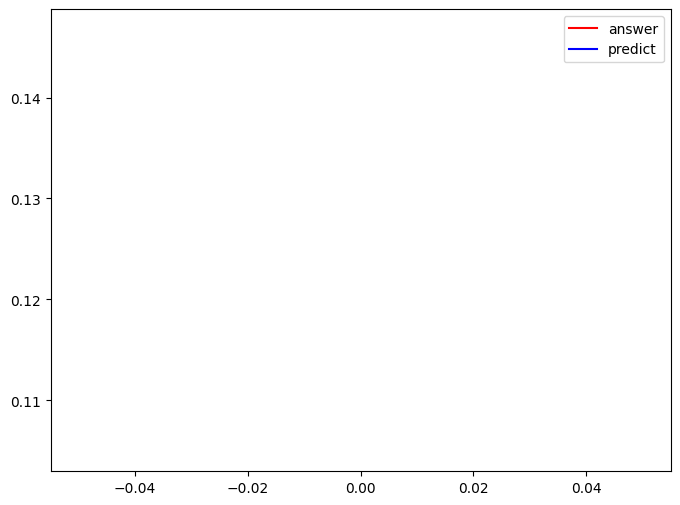

In [43]:
#테스트 셋 1개의 예측 성능 확인
plt.plot(answer_list[0], color = 'r', label = 'answer')
plt.plot(predict_list[0], color = 'b', label = 'predict')

plt.legend()
plt.show()

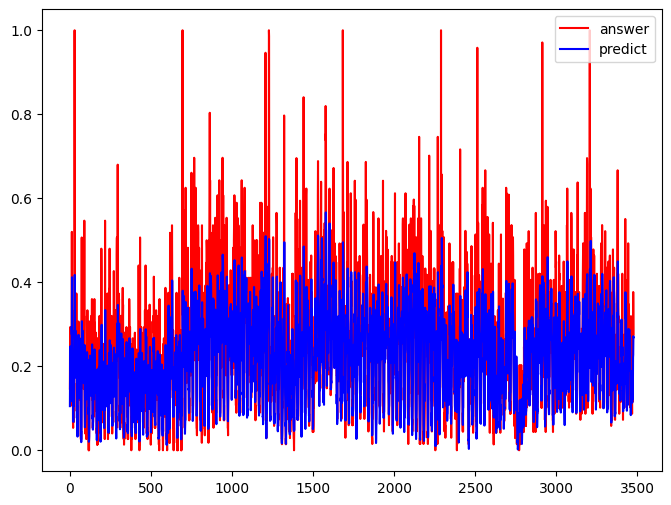

In [44]:
#예측하고자 하는 가구의 예측 성능 확인
plt.plot(answer, color = 'r', label = 'answer')
plt.plot(predict, color = 'b', label = 'predict')

plt.legend()
plt.show()

In [45]:
#예측하고자 하는 가구의 예측 성능 확인
a = answer
b = predict
print('mae = %.4f' %mae(a, b).numpy())
print('mse = %.4f' %mse(a, b).numpy()) 
print('r2_score = %.4f' %r2_score(a, b))
print('RMSE = %.4f' %RMSE(a, b))


mae = 0.0739
mse = 0.0117
r2_score = 0.4610
RMSE = 0.1081
